In [3]:
import collections
import supermarq
import cirq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from qiskit import *

# Introduction

## Artifact Evaluation
This notebook was created to serve as the reproducibility artifact for the paper "SupermarQ: A Scalable Quantum Benchmark Suite" accepted in the 28th IEEE International Symposium on High-Performance Computer Architecture (HPCA-28). The main contribution of this paper includes a quantum benchmark suite comprised of a number of different quantum applications. The software provided within this artifact includes the circuit generators and score functions for each benchmark application. This notebook provides an example of each benchmark: generating the quantum circuits with the provided parameters, simulating their execution via noisy density matrix simulation provided through Cirq (more on this in the following section), and finally computing the performance score of those executions.

This notebook is meant to serve as an overview of the process used to generate and collect the benchmark results that were presented in the above paper. Each benchmark is defined within a file found in the `supermarq/benchmarks/` directory. This file defines a benchmark class that includes a function for generating the quantum circuits, and a function for evaluating the benchmark score.

The first section of this notebook, **Benchmarks**, provides an overview of the benchmarks within the SupermarQ suite. The second section, **Features**, contains examples showing how the feature plots in Figure 1 were created (the corresponding code for the feature plots is contained in `supermarq/features.py`). Finally, the last section **Correlations** uses the raw data stored as Pandas dataframes within the `data/` directory to recreate Figures 4 and 5.

### Simulation vs. Hardware Execution
The benchmark results included in the SupermarQ paper were evaluated on real quantum computers including both superconducting and trapped ion processors. These systems were accessed over the cloud via services provided by IBM Quantum and Braket (Amazon). Access to some of these systems is restricted to certain users and the cost of running quantum programs varies among them. Because of these reasons, it would be impractical to exactly reproduce the results within the SupermarQ paper. Instead, we substitute the hardware executions with circuit simulations conducted via the Cirq SDK. 

### Installation Guide
This artifact was generated using Python 3.8. We recommend creating a fresh python virtual environment. Then, the supermarq software package and all of its dependencies can be installed via:

```
cd SupermarQ_HPCA_Artifact
pip install -r requirements.txt
pip install -e .
```

In [4]:
def noisy_simulation(circuit: cirq.Circuit, p: float) -> collections.Counter:
    """
    Simulate the given circuit under a depolarizing noise model where every
    gate operation has the chance of depolarizing the qubit with probability p.
    """
    
    shots = 1000
    result = cirq.Simulator().run(circuit.with_noise(cirq.depolarize(p=p)),
                                  repetitions=shots)

    num_measured_qubits = []
    for _, op in circuit.findall_operations(cirq.is_measurement):
        num_measured_qubits.append(len(op.qubits))
    raw_counts = result.multi_measurement_histogram(keys=result.measurements.keys())

    # cirq.Result.multi_measurement_histogram returns a collection.Counter object
    # where the keys are tuples of integers and the values are the shot counts.
    # The integers in the keys indicate the bitstring result of each set of measurement tags.
    counts: Dict[str, float] = collections.defaultdict(float)
    for key, val in raw_counts.items():
        bit_list = []
        for int_tag, num_bits in zip(key, num_measured_qubits):
            bit_list.extend(cirq.value.big_endian_int_to_bits(int_tag, bit_count=num_bits))
        counts["".join([str(b) for b in bit_list])] = val / shots

    return collections.Counter(counts)

# Benchmarks

## GHZ

In [6]:
supermarq.ghz.GHZ

supermarq.benchmarks.ghz.GHZ

In [7]:
# Create the benchmark object and circuit
num_qubits = 5
ghz = supermarq.ghz.GHZ(num_qubits)
ghz_circuit = ghz.circuit()
print(ghz_circuit)

0: ───H───@───────────────M───
          │               │
1: ───────X───@───────────M───
              │           │
2: ───────────X───@───────M───
                  │       │
3: ───────────────X───@───M───
                      │   │
4: ───────────────────X───M───


##### definig


In [8]:
#features.py

import cirq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from typing import Union


def cirq_to_qiskit(circuit: cirq.Circuit) -> qiskit.circuit.QuantumCircuit:
    qasm = cirq.circuits.QasmOutput(circuit, sorted(circuit.all_qubits()))
    return qiskit.circuit.QuantumCircuit().from_qasm_str(str(qasm))


def compute_connectivity(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    N = circ.num_qubits
    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    G = nx.Graph()
    for op in dag.two_qubit_ops():
        q1, q2 = op.qargs
        G.add_edge(q1.index, q2.index)

    degree_sum = sum([G.degree(n) for n in G.nodes])

    return degree_sum / (N * (N - 1))


def compute_liveness(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    N = circ.num_qubits
    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    activity_matrix = np.zeros((N, dag.depth()))

    for i, layer in enumerate(dag.layers()):
        for op in layer["partition"]:
            for qubit in op:
                activity_matrix[qubit.index, i] = 1

    return np.sum(activity_matrix) / (N * dag.depth())


def compute_parallelism(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")
    return max(1 - (circ.depth() / len(dag.gate_nodes())), 0)


def compute_measurement(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    """
    measurement feature = # of layers of mid-circuit measurement / circuit depth

    Input
    -----
    circ : QuantumCircuit
    """
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    reset_moments = 0
    gate_depth = dag.depth() - 1

    for layer in dag.layers():
        reset_present = False
        for op in layer['graph'].op_nodes():
            if op.name == 'reset':
                reset_present += True
        if reset_present:
            reset_moments += 1

    return reset_moments / gate_depth


def compute_entanglement(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    return len(dag.two_qubit_ops()) / len(dag.gate_nodes())


def compute_depth(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")
    n_ed = 0
    two_q_gates = set([op.name for op in dag.two_qubit_ops()])
    for name in two_q_gates:
        try:
            n_ed += dag.count_ops_longest_path()[name]
        except KeyError:
            continue
    n_e = len(dag.two_qubit_ops())

    if n_ed == 0:
        return 0

    return n_ed / n_e


def radar_factory(num_vars, frame="circle"):
    """
    (https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = "radar"
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location("N")

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=14)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == "circle":
                return Circle((0.5, 0.5), 0.5)
            elif frame == "polygon":
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == "circle":
                return super()._gen_axes_spines()
            elif frame == "polygon":
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self, spine_type="circle", path=Path.unit_regular_polygon(num_vars)
                )
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes)
                return {"polar": spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def plot_benchmark(data, show=True, savefn=None, spoke_labels=None, legend_loc=(0.75, 0.85)):
    """
    Create a radar plot of the given benchmarks.

    Input
    -----
    data : List
        Contains the title, feature data, and labels in the format:
        [title, [labels], [feature vecs: [con, liv, par, mea, ent] ]]
    """
    plt.rcParams["font.family"] = "Times New Roman"

    if spoke_labels is None:
        spoke_labels = ["Connectivity", "Liveness", "Parallelism", "Measurement", "Entanglement"]

    N = len(spoke_labels)
    theta = radar_factory(N, frame="circle")

    fig, ax = plt.subplots(dpi=150, subplot_kw=dict(projection="radar"))
    # fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    title, labels, case_data = data
    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_rgrids([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
    #             horizontalalignment='center', verticalalignment='center')
    for d, label in zip(case_data, labels):
        ax.plot(theta, d, label=label)
        ax.fill(theta, d, alpha=0.25)
    ax.set_varlabels(spoke_labels)

    ax.legend(loc=legend_loc, labelspacing=0.1, fontsize=11)
    plt.tight_layout()

    if savefn is not None:
        plt.savefig(savefn)

    if show:
        plt.show()

    plt.close()

## bruh

In [9]:
#convert ghz circuit to qiskit circuit

circuit = cirq_to_qiskit(ghz_circuit)

In [12]:
circuit.draw()

┌───┐          ┌─┐                      
 q_0: ┤ H ├──■───────┤M├──────────────────────
      └───┘┌─┴─┐     └╥┘     ┌─┐              
 q_1: ─────┤ X ├──■───╫──────┤M├──────────────
           └───┘┌─┴─┐ ║      └╥┘     ┌─┐      
 q_2: ──────────┤ X ├─╫───■───╫──────┤M├──────
                └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
 q_3: ────────────────╫─┤ X ├─╫───■───╫─┤M├───
                      ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
 q_4: ────────────────╫───────╫─┤ X ├─╫──╫─┤M├
                      ║       ║ └───┘ ║  ║ └╥┘
m0: 5/════════════════╩═══════╩═══════╩══╩══╩═
                      0       1       2  3  4

In [13]:
# analysing the feature vectors

compute_liveness(circuit)



<ipython-input-8-83d30798347a>:57: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  activity_matrix[qubit.index, i] = 1


0.4666666666666667

In [14]:
compute_connectivity(circuit)

<ipython-input-8-83d30798347a>:35: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  G.add_edge(q1.index, q2.index)


0.4

In [15]:
compute_parallelism(circuit)

0

In [16]:
compute_measurement(circuit)

0.0

In [17]:
compute_entanglement(circuit)

0.8

In [18]:
compute_depth(circuit)

1.0

In [19]:
# Perform noisy simulation and evaluate the benchmark score function
ghz_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(ghz_circuit, p=error_prob)
    score = ghz.score(counts)
    ghz_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, GHZ score = {score:.4f}')

With 0.0% error probability, GHZ score = 0.9999
With 0.5% error probability, GHZ score = 0.9170
With 2.0% error probability, GHZ score = 0.7180


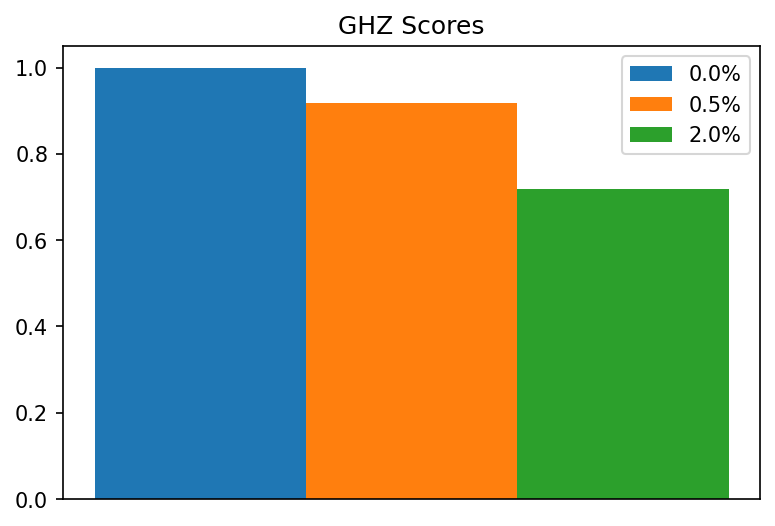

In [20]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(ghz_scores):
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('GHZ Scores')
ax.get_xaxis().set_visible(False)

## Mermin-Bell

In [21]:
supermarq.mermin_bell.MerminBell

supermarq.benchmarks.mermin_bell.MerminBell

In [22]:
# Create the benchmark object and circuit
num_qubits = 3
merminbell = supermarq.mermin_bell.MerminBell(num_qubits)
mb_circuit = merminbell.circuit()
print(mb_circuit)

0: ───Rx(-0.5π)───@───────────@───────X───X───S───@───H───────M───
                  │           │       │   │       │           │
1: ───────────────X───@───H───┼───@───┼───@───────@───S───H───M───
                      │       │   │   │                       │
2: ───────────────────X───H───X───X───@───S───H───────────────M───


In [23]:
circuit = cirq_to_qiskit(mb_circuit)

In [24]:
compute_parallelism(circuit)

0.1875

In [25]:
compute_connectivity(circuit)

<ipython-input-8-83d30798347a>:35: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  G.add_edge(q1.index, q2.index)


1.0

In [26]:
# Perform noisy simulation and evaluate the benchmark score function
merminbell_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(mb_circuit, p=error_prob)
    score = merminbell.score(counts)
    merminbell_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, MerminBell score = {score:.4f}')

With 0.0% error probability, MerminBell score = 1.0000
With 0.5% error probability, MerminBell score = 0.9190
With 2.0% error probability, MerminBell score = 0.7430


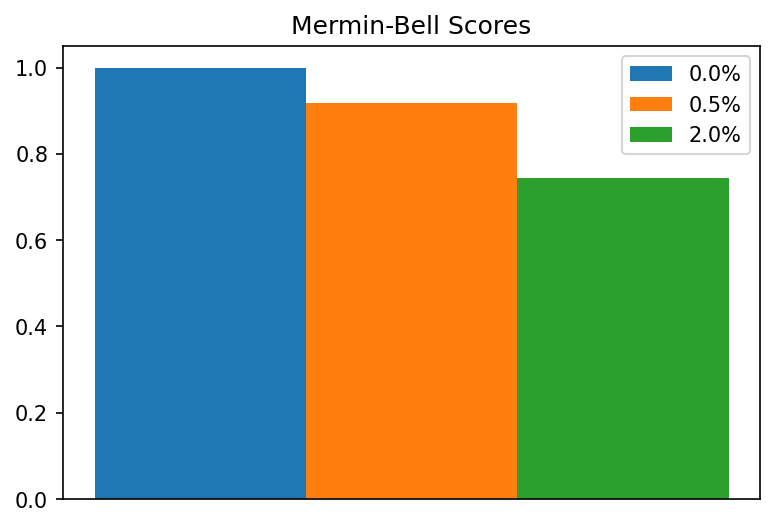

In [27]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(merminbell_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Mermin-Bell Scores')
ax.get_xaxis().set_visible(False)

## Bit Code

In [ ]:
supermarq.bit_code.BitCode?

In [ ]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
bit_state = [0, 1, 0]
bitcode = supermarq.bit_code.BitCode(num_data_qubits, num_rounds, bit_state)
bitcode_circuit = bitcode.circuit()
print(bitcode_circuit)

In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
bitcode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(bitcode_circuit, p=error_prob)
    score = bitcode.score(counts)
    bitcode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, BitCode score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(bitcode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Bit Code Scores')
ax.get_xaxis().set_visible(False)

## Phase Code

In [29]:
supermarq.phase_code.PhaseCode

supermarq.benchmarks.phase_code.PhaseCode

In [30]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
phase_state = [0, 1, 0]
phasecode = supermarq.phase_code.PhaseCode(num_data_qubits, num_rounds, phase_state)
phasecode_circuit = phasecode.circuit()
print(phasecode_circuit)

0: ───H───H───@───H───H───────────────────────────────@───H───H───────────────────────────M('meas_all')───
              │                                       │                                   │
1: ───H───────@───@───H───────────M('mcm0')───R───H───@───@───H───────────M('mcm1')───R───M───────────────
                  │               │                       │               │               │
2: ───X───H───H───@───@───H───H───┼───────────────────────@───@───H───H───┼───────────────M───────────────
                      │           │                           │           │               │
3: ───H───────────────@───@───H───M───────────R───H───────────@───@───H───M───────────R───M───────────────
                          │                                       │                       │
4: ───H───H───────────────@───H───H───────────────────────────────@───H───H───────────────M───────────────


In [31]:
# Perform noisy simulation and evaluate the benchmark score function
phasecode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(phasecode_circuit, p=error_prob)
    score = phasecode.score(counts)
    phasecode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, PhaseCode score = {score:.4f}')

With 0.0% error probability, PhaseCode score = 0.0000
With 0.5% error probability, PhaseCode score = 0.0000
With 2.0% error probability, PhaseCode score = 0.0000


In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(phasecode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Phase Code Scores')
ax.get_xaxis().set_visible(False)

## VQE

In [28]:
supermarq.

AttributeError: module 'supermarq' has no attribute 'vqe_proxy'

In [ ]:
# Create the benchmark object and circuit
num_qubits = 3
num_layers = 2
vqe = supermarq.vqe_proxy.VQEProxy(num_qubits, num_layers)
vqe_circuit = vqe.circuit()
print('Z basis circuit:')
print(vqe_circuit[0])
print('\nX basis circuit:')
print(vqe_circuit[1])

In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
vqe_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    z_counts = noisy_simulation(vqe_circuit[0], p=error_prob)
    x_counts = noisy_simulation(vqe_circuit[1], p=error_prob)
    score = vqe.score([z_counts, x_counts])
    vqe_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, VQE score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqe_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('VQE Scores')
ax.get_xaxis().set_visible(False)

## Hamiltonian Simulation

In [32]:
supermarq.hamiltonian_simulation.HamiltonianSimulation

supermarq.benchmarks.hamiltonian_simulation.HamiltonianSimulation

In [ ]:
# Create the benchmark object and circuit
num_qubits = 3
time_step = 1
total_time = 2
hamsim = supermarq.hamiltonian_simulation.HamiltonianSimulation(num_qubits, time_step, total_time)
hamsim_circuit = hamsim.circuit()
print(hamsim_circuit)

In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
hamsim_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(hamsim_circuit, p=error_prob)
    score = hamsim.score(counts)
    hamsim_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Hamiltonian Simulation score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(hamsim_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Hamiltonian Simulation Scores')
ax.get_xaxis().set_visible(False)

## Fermionic-SWAP QAOA

In [33]:
supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy

supermarq.benchmarks.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy

In [ ]:
# Create the benchmark object and circuit
num_qubits = 3
fermionic_qaoa = supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits)
fqaoa_circuit = fermionic_qaoa.circuit()
print(fqaoa_circuit)

In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
fqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(fqaoa_circuit, p=error_prob)
    score = fermionic_qaoa.score(counts)
    fqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Fermionic SWAP QAOA score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(fqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Fermionic SWAP QAOA Scores')
ax.get_xaxis().set_visible(False)

## Vanilla QAOA

In [ ]:
supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy

In [ ]:
# Create the benchmark object and circuit
num_qubits = 3
vanilla_qaoa = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits)
vqaoa_circuit = vanilla_qaoa.circuit()
print(vqaoa_circuit)

In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
vqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(vqaoa_circuit, p=error_prob)
    score = vanilla_qaoa.score(counts)
    vqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Vanilla QAOA score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Vanilla QAOA Scores')
ax.get_xaxis().set_visible(False)

# Features

In [ ]:
# GHZ feature example
title = 'GHZ'
labels = ['3 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [3, 5, 7, 11]:
    circ = supermarq.ghz.GHZ(nq).circuit()
    con = supermarq.features.compute_connectivity(circ)
    liv = supermarq.features.compute_liveness(circ)
    par = supermarq.features.compute_parallelism(circ)
    mea = supermarq.features.compute_measurement(circ)
    ent = supermarq.features.compute_entanglement(circ)
    dep = supermarq.features.compute_depth(circ)
    feature_vecs.append([con, liv, par, mea, ent, dep])
    
spoke_labels = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD']
supermarq.features.plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.1, 0.25))

In [ ]:
# Vanilla QAOA feature example
title = 'QAOA Vanilla Proxy'
labels = ['4 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [4, 5, 7, 11]:
    circ = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(nq).circuit()
    con = supermarq.features.compute_connectivity(circ)
    liv = supermarq.features.compute_liveness(circ)
    par = supermarq.features.compute_parallelism(circ)
    mea = supermarq.features.compute_measurement(circ)
    ent = supermarq.features.compute_entanglement(circ)
    dep = supermarq.features.compute_depth(circ)
    feature_vecs.append([con, liv, par, mea, ent, dep])
    
spoke_labels = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD']
supermarq.features.plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.33, 0.05))

# Correlations

In [ ]:
import pandas as pd
from plotting_functions import heatmap, annotate_heatmap, regression_plot

In [ ]:
# Load the dataframes from the data/ directory
feature_df = pd.read_pickle('data/feature_dataframe.pickle')
score_df = pd.read_pickle('data/benchmark_scores_dataframe.pickle')

In [ ]:
# Create the correlation dataframes including the error-correction benchmarks
correlation_wEC_df = pd.DataFrame(data=None, index=score_df.index, columns=feature_df.columns)
correlation_wEC_df.head()

In [ ]:
for feature in correlation_wEC_df.columns:
    
    application_features = feature_df.loc[:, feature]
    
    for device in correlation_wEC_df.index:
        scores = score_df.loc[device, :]

        x, y = [], []
        for benchmark in scores.index:
            #if 'code' in benchmark:
            #    continue
            if isinstance(scores.loc[benchmark], tuple):
                x.append(application_features.loc[benchmark])
                y.append(scores.loc[benchmark][0])

        X = np.array(x)[:, np.newaxis]
        Y = np.array(y)
        model = LinearRegression().fit(X, Y)
        correlation = model.score(X, Y)        
        correlation_wEC_df.loc[device, feature] = correlation
correlation_wEC_df.head()

In [ ]:
# Create the correlation dataframes excluding the error-correction benchmarks
correlation_woEC_df = pd.DataFrame(data=None, index=score_df.index, columns=feature_df.columns)
correlation_woEC_df.head()

In [ ]:
for feature in correlation_woEC_df.columns:
    
    application_features = feature_df.loc[:, feature]
    
    for device in correlation_woEC_df.index:
        scores = score_df.loc[device, :]

        x, y = [], []
        for benchmark in scores.index:
            if 'code' in benchmark:
                continue
            if isinstance(scores.loc[benchmark], tuple):
                x.append(application_features.loc[benchmark])
                y.append(scores.loc[benchmark][0])

        X = np.array(x)[:, np.newaxis]
        Y = np.array(y)
        model = LinearRegression().fit(X, Y)
        correlation = model.score(X, Y)        
        correlation_woEC_df.loc[device, feature] = correlation
correlation_woEC_df.head()

In [ ]:
# Plot correlations INCLUDING error-correction Benchmarks
fig, ax = plt.subplots(dpi=300)

rows = ['AQT-4Q', 'IBM-\nCasablanca-7Q', 'IBM-\nGuadalupe-16Q', 'IonQ-11Q', 'IBM-Lagos-7Q', 'IBM-Montreal-27Q', 'IBM-Mumbai-27Q', 'IBM-Santiago-5Q', 'IBM-Toronto-27Q']
cols = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD', 'Qubits', '2q-gates', 'Depth']
subset_df = correlation_wEC_df.loc[:,[ 'Communication', 'Liveness', 'Parallelism', 'midMea', 'Entanglement', 'Depth', 'qubits', 'entangling-gates', 'regular-depth']]
im, _ = heatmap(subset_df.to_numpy(dtype=float), rows, cols, ax=ax,
                cmap="cool", vmin=0, vmax=0.5,
                cbarlabel=r"Coefficient of Determination, $R^2$",
                cbar_kw={'pad':0.01})

annotate_heatmap(im, size=7)

ax.annotate("", xy=(0.668, 1.06), xycoords='axes fraction',
            xytext=(0.668, -0.06), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color='r'))
ax.annotate("", xy=(0.4, -0.028), xycoords='axes fraction',
            xytext=(0.47, -0.028), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.annotate('This work', (0.47,-0.04), xycoords='axes fraction', fontsize=8)
ax.annotate('Typical features', (0.7,-0.04), xycoords='axes fraction', fontsize=8, horizontalalignment='left')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Plot correlations EXCLUDING error-correction Benchmarks
fig, ax = plt.subplots(dpi=300)

rows = ['AQT-4Q', 'IBM-\nCasablanca-7Q', 'IBM-\nGuadalupe-16Q', 'IonQ-11Q', 'IBM-Lagos-7Q', 'IBM-Montreal-27Q', 'IBM-Mumbai-27Q', 'IBM-Santiago-5Q', 'IBM-Toronto-27Q']
cols = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD', 'Qubits', '2q-gates', 'Depth']
subset_df = correlation_woEC_df.loc[:,[ 'Communication', 'Liveness', 'Parallelism', 'midMea', 'Entanglement', 'Depth', 'qubits', 'entangling-gates', 'regular-depth']]
im, _ = heatmap(subset_df.to_numpy(dtype=float), rows, cols, ax=ax,
                cmap="cool", vmin=0, vmax=0.5,
                cbarlabel=r"Coefficient of Determination, $R^2$",
                cbar_kw={'pad':0.01})

annotate_heatmap(im, size=7)

ax.annotate("", xy=(0.668, 1.06), xycoords='axes fraction',
            xytext=(0.668, -0.06), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color='r'))
ax.annotate("", xy=(0.4, -0.028), xycoords='axes fraction',
            xytext=(0.47, -0.028), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.annotate('This work', (0.47,-0.04), xycoords='axes fraction', fontsize=8)
ax.annotate('Typical features', (0.7,-0.04), xycoords='axes fraction', fontsize=8, horizontalalignment='left')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Plot the perfomance correlation of between individual devices and features
print(list(feature_df.columns))
print(list(score_df.index))
device = 'toronto'
feature = 'Entanglement'
regression_plot(device, feature, feature_df, score_df)